# Recurrent Neural Network

## Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import models

from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns

2024-05-20 16:20:50.544511: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-20 16:20:50.546546: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-20 16:20:50.575443: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-20 16:20:50.575471: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-20 16:20:50.576158: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

## Code

### Chargement des données

In [2]:
train_data = np.loadtxt('data/ECG200_TRAIN.tsv', delimiter='\t')
test_data = np.loadtxt('data/ECG200_TEST.tsv', delimiter='\t')

### Préparation des données

In [3]:
# Changer -1 en 0 pour la classification binaire
train_data[train_data[:, 0] == -1, 0] = 0
test_data[test_data[:, 0] == -1, 0] = 0

# Séparation des données d'entraînement et de test
X_train, y_train = train_data[:, 1:], train_data[:, 0]
X_test, y_test = test_data[:, 1:], test_data[:, 0]

# Normalisation des séries temporelles entre 0 et 1
global_max = np.max(np.concatenate((X_train, X_test), axis=0))
global_min = np.min(np.concatenate((X_train, X_test), axis=0))
X_train_normalized = (X_train - global_min) / (global_max - global_min)
X_test_normalized = (X_test - global_min) / (global_max - global_min)

# Remodelage les données d'entrée pour qu'elles aient la forme (batch_size, timesteps, features)
timesteps = 1  ## Nombre de pas de temps en fonction de l'application
X_train_reshaped = X_train_normalized.reshape(-1, timesteps, X_train_normalized.shape[1])
X_test_reshaped = X_test_normalized.reshape(-1, timesteps, X_test_normalized.shape[1])

In [4]:
print(train_data.shape)
print(test_data.shape)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(y_test)

(100, 97)
(100, 97)
(100, 96) (100,)
(100, 96) (100,)
[1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1.
 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1.
 1. 0. 0. 1.]


### Création du modèle RNN (LSTM)

In [5]:
input_shape = (timesteps, X_train_normalized.shape[1])  # Taille de la série temporelle
hidden_units = 8  # Nombre d'unités dans la couche LSTM (not 128 _ best : 16 ?)

input_layer = Input(shape=input_shape)
lstm_layer = LSTM(units=hidden_units)(input_layer)
output_layer = Dense(1, activation='sigmoid')(lstm_layer)  # Classification binaire

model = models.Model(inputs=input_layer, outputs=output_layer)

2024-05-20 16:20:52.202089: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


### Compilation du modèle

In [6]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.summary

### Entrainement du modèle

In [7]:
mini_batch_size = 32 # (same with 64)
history = model.fit(X_train_reshaped, y_train, batch_size=mini_batch_size, epochs=500, validation_split=0.2)

Epoch 1/500
3/3 [==============================] - 2s 178ms/step - loss: 0.6794 - accuracy: 0.7125 - val_loss: 0.6884 - val_accuracy: 0.5500
Epoch 2/500
3/3 [==============================] - 0s 13ms/step - loss: 0.6588 - accuracy: 0.7250 - val_loss: 0.6887 - val_accuracy: 0.5500
Epoch 3/500
3/3 [==============================] - 0s 11ms/step - loss: 0.6409 - accuracy: 0.7250 - val_loss: 0.6925 - val_accuracy: 0.5500
Epoch 4/500
3/3 [==============================] - 0s 11ms/step - loss: 0.6238 - accuracy: 0.7250 - val_loss: 0.6994 - val_accuracy: 0.5500
Epoch 5/500
3/3 [==============================] - 0s 12ms/step - loss: 0.6127 - accuracy: 0.7250 - val_loss: 0.7090 - val_accuracy: 0.5500
Epoch 6/500
3/3 [==============================] - 0s 13ms/step - loss: 0.6012 - accuracy: 0.7250 - val_loss: 0.7190 - val_accuracy: 0.5500
Epoch 7/500
3/3 [==============================] - 0s 11ms/step - loss: 0.5937 - accuracy: 0.7250 - val_loss: 0.7296 - val_accuracy: 0.5500
Epoch 8/500
3/3 [==

### Évaluation du modèle sur les données de test

In [8]:
test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

4/4 [==============================] - 0s 2ms/step - loss: 0.4313 - accuracy: 0.8400
Test Loss: 0.43127477169036865, Test Accuracy: 0.8399999737739563


### Plot

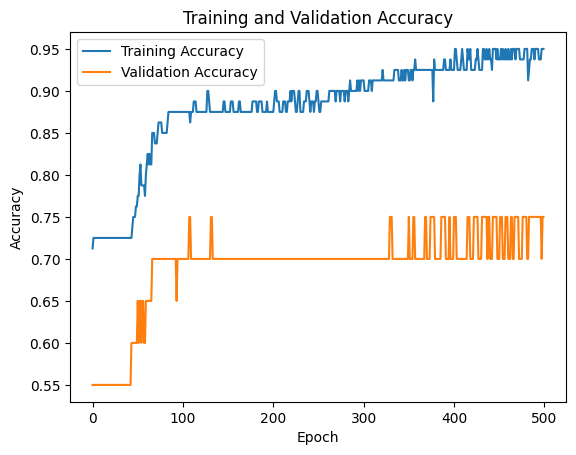

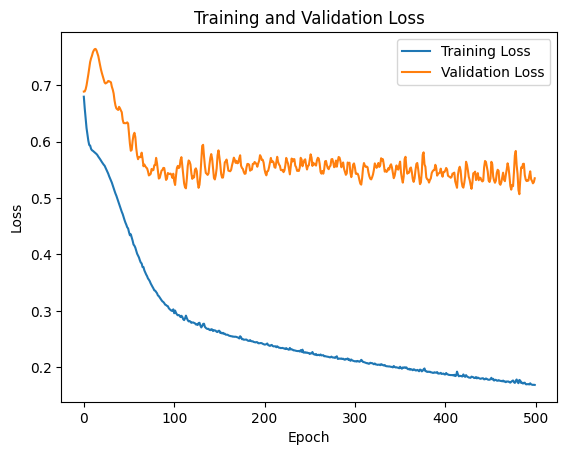

In [9]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Matrice de confusion

In [10]:
# Faire des prédictions sur l'ensemble de test
y_pred = model.predict(X_test_normalized)

# Convertir les probabilités de y_pred en classes binaires
y_pred_classes = (y_pred > 0.5).astype(int).flatten()

# Afficher la matrice de confusion sous forme de heatmap
conf_matrix = confusion_matrix(y_test, y_pred_classes)
class_names = ['Positif', 'Négatif']
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

ValueError: in user code:

    File "/home/sicard/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/home/sicard/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/sicard/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/home/sicard/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/home/sicard/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/sicard/.local/lib/python3.10/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 1, 96), found shape=(None, 96)
